In [1]:
import pandas as pd
# 1. Data preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np


In [2]:
caliope_data = pd.read_csv('./processed_data/caliope/caliope_data.csv')
dataset_barcelona = pd.read_csv('./processed_data/data_ams/dataset_tarragona.csv')
dataset_barcelona_real = pd.read_csv('./processed_data/data_ams/dataset_tarragona_real.csv')


In [3]:
caliope_data = caliope_data.rename(columns={'fecha': 'Date'})
dataset_barcelona = dataset_barcelona.drop('Unnamed: 0', axis=1)
dataset_barcelona_real = dataset_barcelona_real.drop('Unnamed: 0', axis=1)

In [4]:
dataset_barcelona_real

,Date,NO2_nearest_1,NO2_nearest_2,hour,day,month,day_of_week,code,lon,lat
0,2022-12-31 23:00:00,24.0,23.000000,23,31,12,5,ES1120A,1.191975,41.11588
1,2023-01-01 00:00:00,27.0,22.000000,0,1,1,6,ES1120A,1.191975,41.11588
2,2023-01-01 01:00:00,26.0,24.000000,1,1,1,6,ES1120A,1.191975,41.11588
3,2023-01-01 02:00:00,18.0,21.000000,2,1,1,6,ES1120A,1.191975,41.11588
4,2023-01-01 03:00:00,11.0,19.000000,3,1,1,6,ES1120A,1.191975,41.11588
...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31 18:00:00,19.0,14.216695,18,31,12,6,ES1120A,1.191975,41.11588
8756,2023-12-31 19:00:00,19.0,14.216695,19,31,12,6,ES1120A,1.191975,41.11588
8757,2023-12-31 20:00:00,13.0,14.216695,20,31,12,6,ES1120A,1.191975,41.11588
8758,2023-12-31 21:00:00,9.0,14.216695,21,31,12,6,ES1120A,1.191975,41.11588


In [5]:
# Merge the datasets based on Date and code
# Assuming dataset_barcelona has a column for station code that matches 'code' in caliope_data
merged_dataset = pd.merge(
    dataset_barcelona,
    caliope_data[['Date', 'code', 'concentracion_NO2']],
    on=['Date', 'code'],
    how='left'
)

# If you want to keep the original dataset_barcelona with just the new column
dataset_barcelona['caliope_NO2'] = merged_dataset['concentracion_NO2']

merged_dataset_real = pd.merge(
    dataset_barcelona_real,
    caliope_data[['Date', 'code', 'concentracion_NO2']],
    on=['Date', 'code'],
    how='left'
)

# If you want to keep the original dataset_barcelona with just the new column
dataset_barcelona_real['caliope_NO2'] = merged_dataset_real['concentracion_NO2']



In [6]:
# Replace infinite values with mean
dataset_barcelona.loc[dataset_barcelona["caliope_NO2"] == np.inf, "caliope_NO2"] = dataset_barcelona["caliope_NO2"].replace([np.inf, -np.inf], np.nan).mean()
# Replace infinite values with mean
dataset_barcelona_real.loc[dataset_barcelona_real["caliope_NO2"] == np.inf, "caliope_NO2"] = dataset_barcelona_real["caliope_NO2"].replace([np.inf, -np.inf], np.nan).mean()


In [7]:
dataset_barcelona = dataset_barcelona.drop(['Date', 'code'], axis=1)
dataset_barcelona_real = dataset_barcelona_real.drop(['Date', 'code'], axis=1)

In [8]:
dataset_barcelona.fillna(dataset_barcelona.median(), inplace=True)
dataset_barcelona_real.fillna(dataset_barcelona_real.median(), inplace=True)


Random Forest:
RMSE: 7.00
R2 Score: 0.73

XGBoost:
RMSE: 6.94
R2 Score: 0.74

Gradient Boosting:
RMSE: 7.60
R2 Score: 0.69

Support Vector Regression:
RMSE: 7.95
R2 Score: 0.66

Linear Regression:
RMSE: 8.50
R2 Score: 0.61



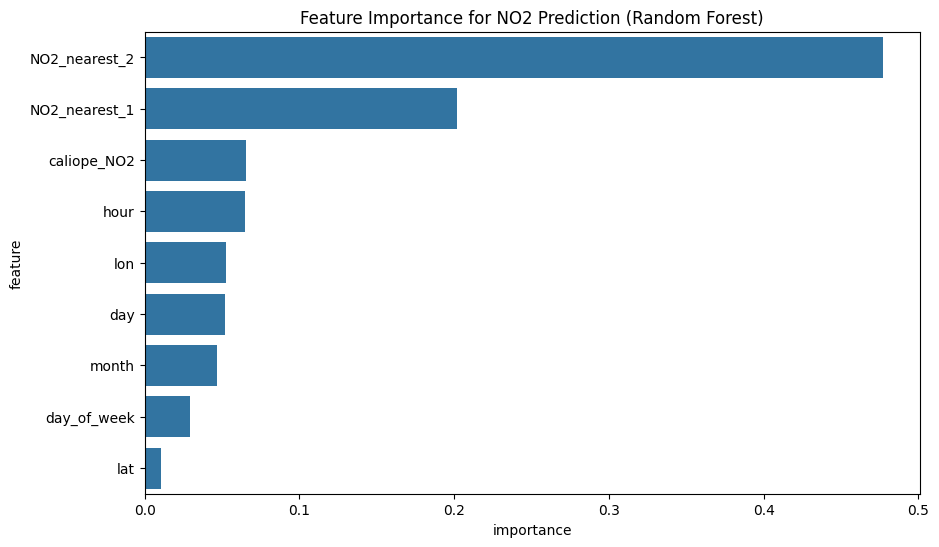

In [10]:
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select features and target
X = dataset_barcelona.drop(['NO2_own'], axis=1)
y = dataset_barcelona['NO2_own']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

# XGBoost
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

# Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)

# Support Vector Regression
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)
svr_pred = svr_model.predict(X_test_scaled)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

# Print evaluation metrics for each model
print("Random Forest:")
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, rf_pred)):.2f}')
print(f'R2 Score: {r2_score(y_test, rf_pred):.2f}\n')

print("XGBoost:")
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred)):.2f}')
print(f'R2 Score: {r2_score(y_test, xgb_pred):.2f}\n')

print("Gradient Boosting:")
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, gb_pred)):.2f}')
print(f'R2 Score: {r2_score(y_test, gb_pred):.2f}\n')

print("Support Vector Regression:")
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, svr_pred)):.2f}')
print(f'R2 Score: {r2_score(y_test, svr_pred):.2f}\n')

print("Linear Regression:")
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, lr_pred)):.2f}')
print(f'R2 Score: {r2_score(y_test, lr_pred):.2f}\n')

# Feature importance plot (using Random Forest as reference)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for NO2 Prediction (Random Forest)')
plt.show()

In [11]:

X_test_scaled = scaler.transform(dataset_barcelona_real)

xgb_pred = xgb_model.predict(X_test_scaled)


In [12]:
dataset_barcelona_real = pd.read_csv('./processed_data/data_ams/dataset_tarragona_real.csv')

# Create a DataFrame with predictions
predictions_df = pd.DataFrame({
    'date': dataset_barcelona_real['Date'],
    'lat': dataset_barcelona_real['lat'],
    'lon': dataset_barcelona_real['lon'], 
    'concentration': xgb_pred
})



In [13]:
predictions_df.index = predictions_df.index + 1

predictions_df.to_csv('results/model_3/model_3_results_2.csv', index=True)
predictions_df

,date,lat,lon,concentration
1,2022-12-31 23:00:00,41.11588,1.191975,29.986511
2,2023-01-01 00:00:00,41.11588,1.191975,19.216949
3,2023-01-01 01:00:00,41.11588,1.191975,19.695217
4,2023-01-01 02:00:00,41.11588,1.191975,17.813652
5,2023-01-01 03:00:00,41.11588,1.191975,13.504875
...,...,...,...,...
8756,2023-12-31 18:00:00,41.11588,1.191975,12.411820
8757,2023-12-31 19:00:00,41.11588,1.191975,12.841913
8758,2023-12-31 20:00:00,41.11588,1.191975,14.446432
8759,2023-12-31 21:00:00,41.11588,1.191975,15.515239


In [19]:
results_1 = pd.read_csv('results/model_3/model_3_results_1.csv')
results_2 = pd.read_csv('results/model_3/model_3_results_2.csv')

final_results = pd.concat([results_1, results_2])
final_results = final_results.drop('id', axis=1)
final_results = final_results.reset_index(drop=True)
final_results.index = final_results.index + 1

final_results.to_csv('results/model_3/model_3_results_final.csv', index=True)
final_results

,date,lat,lon,concentration
1,2022-12-31 23:00:00,41.39216,2.009802,53.084970
2,2023-01-01 00:00:00,41.39216,2.009802,49.099747
3,2023-01-01 01:00:00,41.39216,2.009802,46.015263
4,2023-01-01 02:00:00,41.39216,2.009802,40.811440
5,2023-01-01 03:00:00,41.39216,2.009802,37.460968
...,...,...,...,...
35036,2023-12-31 18:00:00,41.11588,1.191975,12.411820
35037,2023-12-31 19:00:00,41.11588,1.191975,12.841913
35038,2023-12-31 20:00:00,41.11588,1.191975,14.446432
35039,2023-12-31 21:00:00,41.11588,1.191975,15.515239
